In [1]:
import pandas as pd
import numpy as np

In [135]:
df = pd.read_csv('./과제/실전db.csv')

In [3]:
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [4]:
df.sort_values(by="JOIN_DATE").head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
176320,1071641,1970-01-01,CC,221045,A,2020-04-03,1,GN
625539,1686813,1970-01-01,CC,223023,A,2020-10-02,1,YD
226658,859401,1970-01-01,CC,102276,B,2020-04-27,1,SC
226415,654237,1970-01-01,CC,181777,C,2020-04-27,1,BF
226042,1552374,1970-01-01,CC,28018,C,2020-04-26,1,JRR


### 2013년 이후 데이터 필터링

In [13]:
df = df[df["JOIN_DATE"]>="2013-01-01"]
display(df)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [102]:
df["DATE"].min()

'2020-01-01'

# Cohort 분석 시도 1

### 사본 temp 생성

In [81]:
temp = df.copy()

### 필요없는 컬럼 제거

In [82]:
temp.drop(["D_TYPE","STORE_ID","GOODS_TYPE","AD1"],inplace=True, axis=1)
temp.head()

,USER_ID,JOIN_DATE,DATE,COUNT
0,2858,2014-01-07,2020-01-01,1
1,5647,2014-02-14,2020-01-01,1
2,33314,2014-11-20,2020-01-01,1
3,37001,2014-12-04,2020-01-01,1
4,37819,2014-12-07,2020-01-01,1


### JOIN_DATE, DATE 컬럼 시계열 데이터로 변환

In [83]:
temp["DATE"] = pd.to_datetime(temp["DATE"])

In [84]:
temp["JOIN_DATE"] = pd.to_datetime(temp["JOIN_DATE"])

### USE_PERIOD로 기간 생성

In [85]:
temp['USE_PERIOD']=temp['DATE'].dt.strftime('%Y-%m')
temp.head()

,USER_ID,JOIN_DATE,DATE,COUNT,USE_PERIOD
0,2858,2014-01-07,2020-01-01,1,2020-01
1,5647,2014-02-14,2020-01-01,1,2020-01
2,33314,2014-11-20,2020-01-01,1,2020-01
3,37001,2014-12-04,2020-01-01,1,2020-01
4,37819,2014-12-07,2020-01-01,1,2020-01


### 각각의 사용을 모두 집계하는 것이 아니라 순유저(UV)로 집계

In [94]:
grouped = temp.groupby(['JOIN_DATE', 'USE_PERIOD'])

In [95]:
cohorts = grouped['USER_ID'].nunique()

In [96]:
cohorts.head()

JOIN_DATE   USE_PERIOD
2013-12-16  2020-01       1
            2020-12       1
2013-12-17  2020-01       1
            2020-02       1
            2020-03       1
Name: USER_ID, dtype: int64

In [97]:
cohorts=cohorts.reset_index()
cohorts.head()

,JOIN_DATE,USE_PERIOD,USER_ID
0,2013-12-16,2020-01,1
1,2013-12-16,2020-12,1
2,2013-12-17,2020-01,1
3,2013-12-17,2020-02,1
4,2013-12-17,2020-03,1


In [98]:
cohorts.rename({'USER_ID':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,JOIN_DATE,USE_PERIOD,TotalUsers
0,2013-12-16,2020-01,1
1,2013-12-16,2020-12,1
2,2013-12-17,2020-01,1
3,2013-12-17,2020-02,1
4,2013-12-17,2020-03,1


In [103]:
each_period=cohorts['JOIN_DATE'].value_counts().sort_index()
each_period.to_frame().head()

,JOIN_DATE
2013-12-16,2
2013-12-17,10
2013-12-18,1
2013-12-21,2
2013-12-22,1


### USER_ID를 index로 만듬

In [86]:
#temp.set_index("USER_ID",inplace=True)

In [87]:
#temp.head()

### 각 유저의 첫 경험이 언제인지 확인하기 (JOIN_DATE컬럼으로 만들어야 하나 아님 df의 DATE컬럼으로 만들어야하나)

In [88]:
#FIRST_ORDER = temp.groupby(temp.index)["DATE"].min()

### FIRST_ORDER 컬럼 생성

In [89]:
#temp["FIRST_ORDER"] = FIRST_ORDER

In [90]:
#temp

### FIRST_ORDER 컬럼 시계열 데이터로 바꿈

In [91]:
#temp["FIRST_ORDER"] = pd.to_datetime(temp["FIRST_ORDER"])

In [92]:
#FIRST_ORDER = FIRST_ORDER.dt.strftime('%Y-%m')
#FIRST_ORDER.head()

In [93]:
#temp.reset_index(inplace=True)
#temp.head(40)

# Cohort 분석 시도 2

In [146]:
temp2 = df.copy()

In [147]:
temp2.groupby(["USER_ID","DATE"])["COUNT"].count()

USER_ID  DATE      
224      2020-01-12    1
         2020-12-09    1
232      2020-01-19    1
         2020-01-26    1
         2020-01-27    1
                      ..
1830551  2020-12-31    1
1830570  2020-12-31    1
1830580  2020-12-31    1
1830589  2020-12-31    1
1830598  2020-12-31    1
Name: COUNT, Length: 879271, dtype: int64

In [148]:
temp2.columns

Index(['USER_ID', 'JOIN_DATE', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'DATE',
       'COUNT', 'AD1'],
      dtype='object')

In [149]:
temp2.drop(['JOIN_DATE','D_TYPE','STORE_ID','GOODS_TYPE','AD1'],
        axis=1,inplace=True)
temp2.head()

,USER_ID,DATE,COUNT
0,2858,2020-01-01,1
1,5647,2020-01-01,1
2,33314,2020-01-01,1
3,37001,2020-01-01,1
4,37819,2020-01-01,1


In [150]:
temp2["COUNT"].sort_values(ascending=False)

729776    61
748372    59
751974    58
726277    55
767392    53
          ..
583299     1
583298     1
583297     1
583296     1
0          1
Name: COUNT, Length: 879271, dtype: int64

In [151]:
temp2[temp2["COUNT"] == 61]

,USER_ID,DATE,COUNT
729776,999665,2020-11-07,61


In [152]:
temp2["USER_ID"].dtypes

dtype('int64')

### 1. 사용일자(DATE) 칼럼으로 단위 기간 만들기

In [153]:
temp2["DATE"]=pd.to_datetime(temp2["DATE"])

In [154]:
# DATE컬럼 데이터를 시계열 데이터로 만들고 새로운 컬럼 추가. 
temp2['OrderPeriod']=temp2['DATE'].dt.strftime('%Y-%m')

In [155]:
temp2.head()

,USER_ID,DATE,COUNT,OrderPeriod
0,2858,2020-01-01,1,2020-01
1,5647,2020-01-01,1,2020-01
2,33314,2020-01-01,1,2020-01
3,37001,2020-01-01,1,2020-01
4,37819,2020-01-01,1,2020-01


### 2. 유저의 첫번째 사용일 토대로 유저별 코호트 그룹 설정하기
- 동일한 경험이란 첫 번째 사용일.
- 각각의 raw에 고객ID별 첫 번째 주문일자를 추가.

In [156]:
temp2.set_index('USER_ID',inplace=True)
temp2.head()

,DATE,COUNT,OrderPeriod
USER_ID,,,
2858,2020-01-01,1,2020-01
5647,2020-01-01,1,2020-01
33314,2020-01-01,1,2020-01
37001,2020-01-01,1,2020-01
37819,2020-01-01,1,2020-01


In [157]:
FirstOrder=temp2.groupby(temp2.index)['DATE'].min()
FirstOrder.head()

USER_ID
224   2020-01-12
232   2020-01-19
342   2020-10-31
565   2020-08-27
729   2020-09-05
Name: DATE, dtype: datetime64[ns]

In [158]:
FirstOrder=FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

USER_ID
224    2020-01
232    2020-01
342    2020-10
565    2020-08
729    2020-09
Name: DATE, dtype: object

In [159]:
temp2['FirstOrder']=FirstOrder
temp2.reset_index(inplace=True)
temp2.head()

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
0,2858,2020-01-01,1,2020-01,2020-01
1,5647,2020-01-01,1,2020-01,2020-01
2,33314,2020-01-01,1,2020-01,2020-01
3,37001,2020-01-01,1,2020-01,2020-01
4,37819,2020-01-01,1,2020-01,2020-01


In [160]:
temp2[temp2["USER_ID"] == 33314]

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
2,33314,2020-01-01,1,2020-01,2020-01
235563,33314,2020-05-01,1,2020-05,2020-01
239229,33314,2020-05-03,1,2020-05,2020-01


### 3. 코호트 그룹과 주문기간으로 데이터 집계하기


In [161]:
grouped = temp2.groupby(['FirstOrder', 'OrderPeriod'])

In [163]:
cohorts=grouped['USER_ID'].nunique()

In [167]:
cohorts=cohorts.reset_index()
cohorts.head()

,FirstOrder,OrderPeriod,USER_ID
0,2020-01,2020-01,26410
1,2020-01,2020-02,9420
2,2020-01,2020-03,6898
3,2020-01,2020-04,7067
4,2020-01,2020-05,7211


In [169]:
cohorts.rename({'USER_ID':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2020-01,2020-01,26410
1,2020-01,2020-02,9420
2,2020-01,2020-03,6898
3,2020-01,2020-04,7067
4,2020-01,2020-05,7211


In [170]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2020-01    12
2020-02    11
2020-03    10
2020-04     9
2020-05     8
2020-06     7
2020-07     6
2020-08     5
2020-09     4
2020-10     3
2020-11     2
2020-12     1
Name: FirstOrder, dtype: int64

In [186]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [188]:
cohorts['CohortPeriod']=cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2020-01,2020-01,26410,0
1,2020-01,2020-02,9420,1
2,2020-01,2020-03,6898,2
3,2020-01,2020-04,7067,3
4,2020-01,2020-05,7211,4
5,2020-01,2020-06,6597,5
6,2020-01,2020-07,6675,6
7,2020-01,2020-08,5839,7
8,2020-01,2020-09,5012,8
9,2020-01,2020-10,5824,9


In [189]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2020-01    0                2020-01       26410
           1                2020-02        9420
           2                2020-03        6898
           3                2020-04        7067
           4                2020-05        7211

In [190]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,26410.0,9420.0,6898.0,7067.0,7211.0,6597.0,6675.0,5839.0,5012.0,5824.0,5482.0,3884.0
2020-02,15318.0,4187.0,3686.0,3587.0,3246.0,3231.0,2861.0,2450.0,2762.0,2593.0,1923.0,NaN
2020-03,12593.0,3932.0,3234.0,2785.0,2758.0,2414.0,2210.0,2347.0,2084.0,1645.0,NaN,NaN
2020-04,12871.0,3539.0,2866.0,2775.0,2309.0,1972.0,2261.0,1946.0,1447.0,NaN,NaN,NaN
2020-05,13822.0,3542.0,3075.0,2460.0,2071.0,2415.0,2113.0,1459.0,NaN,NaN,NaN,NaN
2020-06,13171.0,3621.0,2703.0,2163.0,2354.0,2159.0,1449.0,NaN,NaN,NaN,NaN,NaN
2020-07,13975.0,3371.0,2462.0,2613.0,2343.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,11931.0,2787.0,2499.0,2160.0,1607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,10169.0,2923.0,2224.0,1636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
cohorts[0]


FirstOrder
2020-01    26410.0
2020-02    15318.0
2020-03    12593.0
2020-04    12871.0
2020-05    13822.0
2020-06    13171.0
2020-07    13975.0
2020-08    11931.0
2020-09    10169.0
2020-10    13333.0
2020-11    12931.0
2020-12     8901.0
Name: 0, dtype: float64

In [192]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,1.0,0.356683,0.261189,0.267588,0.273041,0.249792,0.252745,0.221090,0.189777,0.220523,0.207573,0.147066
2020-02,1.0,0.273339,0.240632,0.234169,0.211908,0.210928,0.186774,0.159943,0.180311,0.169278,0.125539,NaN
2020-03,1.0,0.312237,0.256809,0.221155,0.219011,0.191694,0.175494,0.186373,0.165489,0.130628,NaN,NaN
2020-04,1.0,0.274959,0.222671,0.215601,0.179396,0.153213,0.175666,0.151193,0.112423,NaN,NaN,NaN
2020-05,1.0,0.256258,0.222471,0.177977,0.149834,0.174721,0.152872,0.105556,NaN,NaN,NaN,NaN
2020-06,1.0,0.274922,0.205224,0.164224,0.178726,0.163921,0.110014,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.241216,0.176172,0.186977,0.167657,0.110912,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,1.0,0.233593,0.209454,0.181041,0.134691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,1.0,0.287442,0.218704,0.160881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


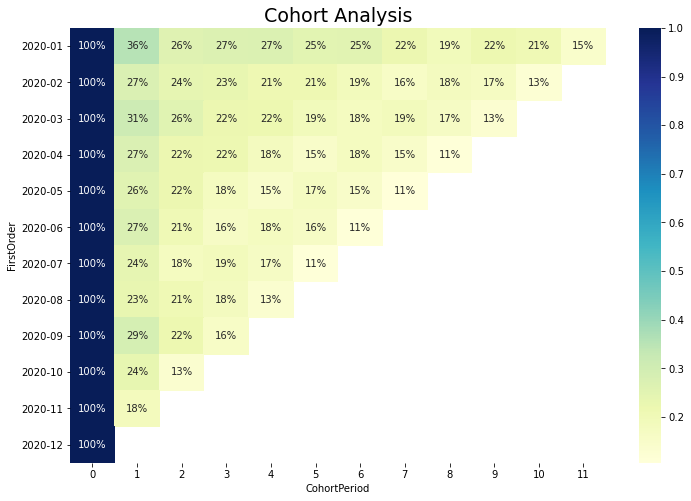

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=19)
sns.heatmap(user_retention, cmap ="YlGnBu", annot=True, fmt='.0%')
plt.show()

표를 가로로 보면 유저의 라이프 사이클을 볼 수 있고 세로로 보면 프로덕트의 라이프 사이클을 볼 수 있다. 